In [1]:
import os, sys
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import torch as t
from torch import nn, Tensor
from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from dataclasses import dataclass
import numpy as np
import einops
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple, Any
from functools import partial
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
from rich.table import Table
from IPython.display import display, HTML
from pathlib import Path
import pandas as pd
pd.options.plotting.backend = "plotly"
import matplotlib.pyplot as plt

chapter = "chapter1_transformer_interp"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = (exercises_dir / "part4_superposition_and_saes").resolve()
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from plotly_utils import imshow, line, hist
from part31_superposition_and_saes.utils import (
    plot_features_in_2d,
    plot_features_in_Nd,
    plot_features_in_Nd_discrete,
    plot_correlated_features,
    plot_feature_geometry,
    frac_active_line_plot,
)
device = t.device("cuda" if t.cuda.is_available() else "cpu")

if not t.backends.mps.is_available():
    if not t.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = t.device("mps")

MAIN = __name__ == "__main__"

In [2]:
def linear_lr(step, steps):
    return (1 - (step / steps))

def constant_lr(*_):
    return 1.0

def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))


@dataclass
class Config:
    # We optimize n_instances models in a single training loop to let us sweep over
    # sparsity or importance curves  efficiently. You should treat `n_instances` as
    # kinda like a batch dimension, but one which is built into our training setup.
    n_instances: int
    n_features: int = 5
    n_hidden: int = 2
    n_correlated_pairs: int = 0
    n_anticorrelated_pairs: int = 0
    activation_fn: Any = F.relu
    optim_fn: Any = t.optim.Adam


class Model(nn.Module):
    W: Float[Tensor, "n_instances n_hidden n_features"]
    b_final: Float[Tensor, "n_instances n_features"]

    def __init__(
        self,
        cfg: Config,
        feature_probability: Optional[Union[float, Tensor]] = None,
        importance: Optional[Union[float, Tensor]] = None,
        device = device,
    ):
        super().__init__()
        self.cfg = cfg

        if feature_probability is None: feature_probability = t.ones(())
        if isinstance(feature_probability, float): feature_probability = t.tensor(feature_probability)
        self.feature_probability = feature_probability.to(device)
        if importance is None: importance = t.ones(())
        if isinstance(importance, float): importance = t.tensor(importance)
        self.importance = importance.to(device).broadcast_to((cfg.n_instances, cfg.n_features))

        self.W = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_hidden, cfg.n_features))))
        self.b_final = nn.Parameter(t.zeros((cfg.n_instances, cfg.n_features)))
        self.to(device)
        
        self.activation_fn = cfg.activation_fn
        self.optim_fn = cfg.optim_fn


    def forward(
        self,
        features: Float[Tensor, "... instances features"]
    ) -> Float[Tensor, "... instances features"]:

        h = einops.einsum(features, self.W, "... instances features, instances n_hidden features -> ... instances n_hidden")
        
        output = einops.einsum(h, self.W, "... instances n_hidden, instances n_hidden features -> ... instances features")
        
        return self.activation_fn(output + self.b_final).to(device)


    def generate_batch(self, batch_size) -> Float[Tensor, "batch_size instances features"]:
        '''
        Generates a batch of data. We'll return to this function later when we apply correlations.
        '''
        features = t.rand((batch_size, self.cfg.n_instances, self.cfg.n_features), device = self.W.device)
    
        feature_seed = t.rand((batch_size, self.cfg.n_instances, self.cfg.n_features), device = self.W.device)
        
        feat_is_present = feature_seed <= self.feature_probability
        
        batch = t.where(feat_is_present, features, 0.0)
        
        return batch


    def calculate_loss(
        self,
        out: Float[Tensor, "batch instances features"],
        batch: Float[Tensor, "batch instances features"],
    ) -> Float[Tensor, ""]:
        '''
        Calculates the loss for a given batch, using this loss described in the Toy Models paper:

            https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-setup-loss

        Remember, `model.importance` will always have shape (n_instances, n_features).
        '''
        squared_loss = self.importance * (batch - out) ** 2
    
        loss = einops.reduce(squared_loss, "batch instances features -> instances", "mean")
        
        summed_loss = loss.sum()
        
        return summed_loss, loss


    def optimize(
        self,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
    ):
        '''
        Optimizes the model using the given hyperparameters.
        '''
        optimizer = self.optim_fn(list(self.parameters()), lr=lr)

        progress_bar = tqdm(range(steps))
        
        losses = []
        summed_losses = []

        for step in progress_bar:

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group['lr'] = step_lr

            # Optimize
            optimizer.zero_grad()
            batch = self.generate_batch(batch_size)
            out = self(batch)
            summed_loss, loss = self.calculate_loss(out, batch)
            losses.append(loss.detach().cpu().clone().numpy().tolist())
            summed_losses.append(summed_loss.detach().cpu().clone().item())
            summed_loss.backward()
            optimizer.step()

            # Display progress bar
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(loss=summed_loss.item()/self.cfg.n_instances, lr=step_lr)
                
        return summed_losses,losses

In [3]:
def feature_probability(n_instances):
    feature_prob = (50 ** -t.linspace(0, 1, n_instances))
    feature_prob = einops.rearrange(feature_prob, "instances -> instances ()")
    return feature_prob

def feature_importance(n_features):
    importance = (0.9 ** t.arange(n_features))
    importance = einops.rearrange(importance, "features -> () features")
    return importance
    

In [19]:
cfg = Config(
    n_instances = 8,
    n_features = 5,
    n_hidden = 2,
)

# importance varies within features for each instance
importance = feature_importance(cfg.n_features)

# sparsity is the same for all features in a given instance, but varies over instances
feature_prob = feature_probability(cfg.n_instances)

In [20]:
model = Model(
    cfg = cfg,
    device = device,
    importance = importance,
    feature_probability = feature_prob,
)
summed_losses, losses = model.optimize(steps=10_000)

  0%|          | 0/10000 [00:00<?, ?it/s]

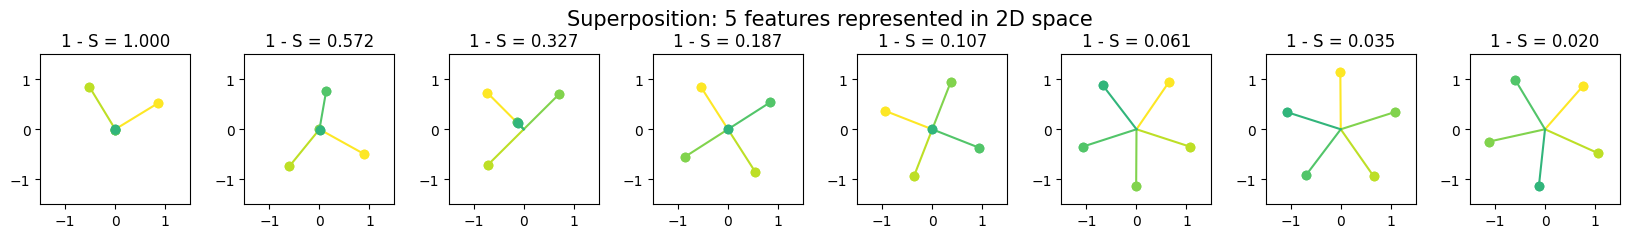

In [21]:
plot_features_in_2d(
    model.W.detach(),
    colors = model.importance,
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    subplot_titles = [f"1 - S = {i:.3f}" for i in feature_prob.squeeze()],
)

In [4]:
def diff_activation_runs(activation_fn):
    
    cfg = Config(
        n_instances = 8,
        n_features = 5,
        n_hidden = 2,
        activation_fn=activation_fn
    )

    # importance varies within features for each instance
    importance = feature_importance(cfg.n_features)

    # sparsity is the same for all features in a given instance, but varies over instances
    feature_prob = feature_probability(cfg.n_instances)
    
    model = Model(
        cfg = cfg,
        device = device,
        importance = importance,
        feature_probability = feature_prob,
    )
    summed_losses, losses = model.optimize(steps=10_000)
    
    plot_features_in_2d(
        model.W.detach(),
        colors = model.importance,
        title = f"Superposition: {cfg.n_features} features represented in 2D space",
        subplot_titles = [f"1 - S = {i:.3f}" for i in feature_prob.squeeze()],
    )
    
def diff_optim_runs(optim_fn):
    
    cfg = Config(
        n_instances = 8,
        n_features = 5,
        n_hidden = 2,
        optim_fn=optim_fn
    )

    # importance varies within features for each instance
    importance = feature_importance(cfg.n_features)

    # sparsity is the same for all features in a given instance, but varies over instances
    feature_prob = feature_probability(cfg.n_instances)
    
    model = Model(
        cfg = cfg,
        device = device,
        importance = importance,
        feature_probability = feature_prob,
    )
    summed_losses, losses = model.optimize(steps=10_000)
    
    plot_features_in_2d(
        model.W.detach(),
        colors = model.importance,
        title = f"Superposition: {cfg.n_features} features represented in 2D space",
        subplot_titles = [f"1 - S = {i:.3f}" for i in feature_prob.squeeze()],
    )

<function relu at 0x10a4e4310>


  0%|          | 0/10000 [00:00<?, ?it/s]

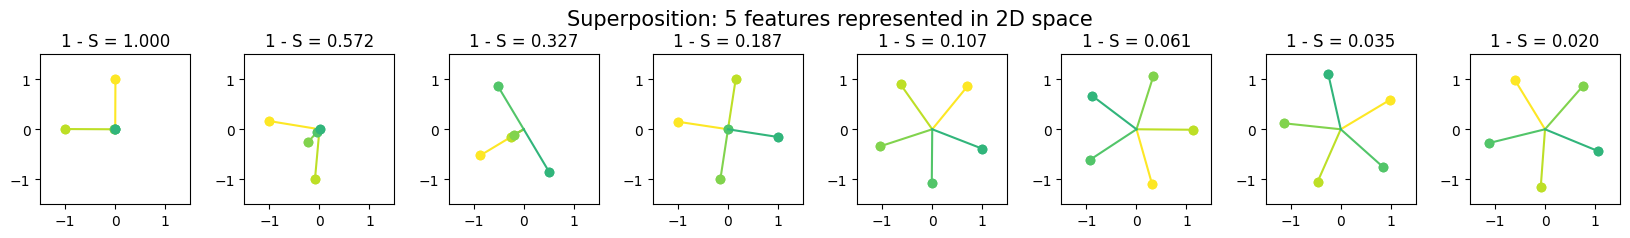

<function tanh at 0x10a4e4d30>


  0%|          | 0/10000 [00:00<?, ?it/s]

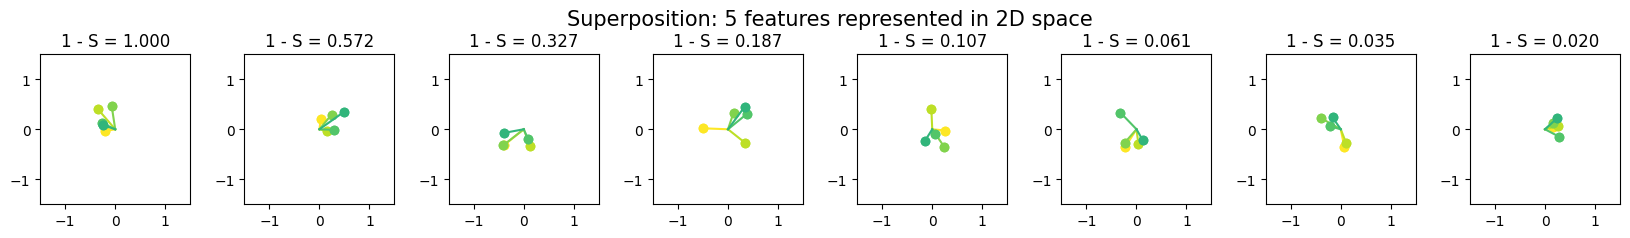

<built-in function gelu>


  0%|          | 0/10000 [00:00<?, ?it/s]

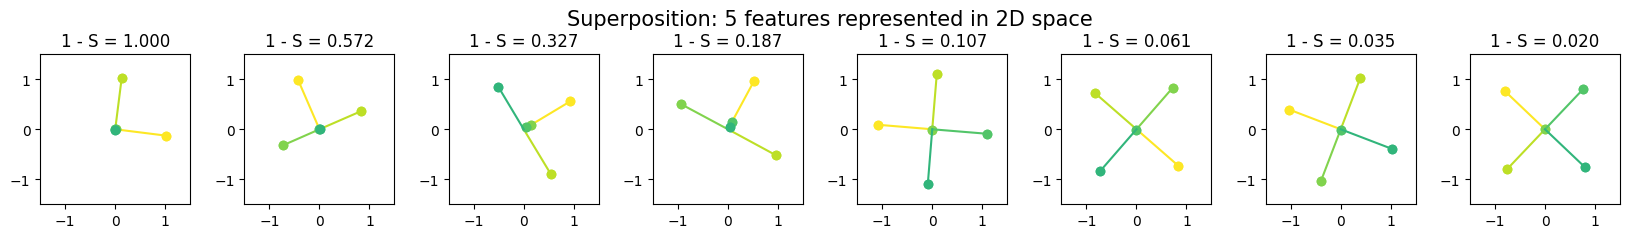

<function elu at 0x10a4e4550>


  0%|          | 0/10000 [00:00<?, ?it/s]

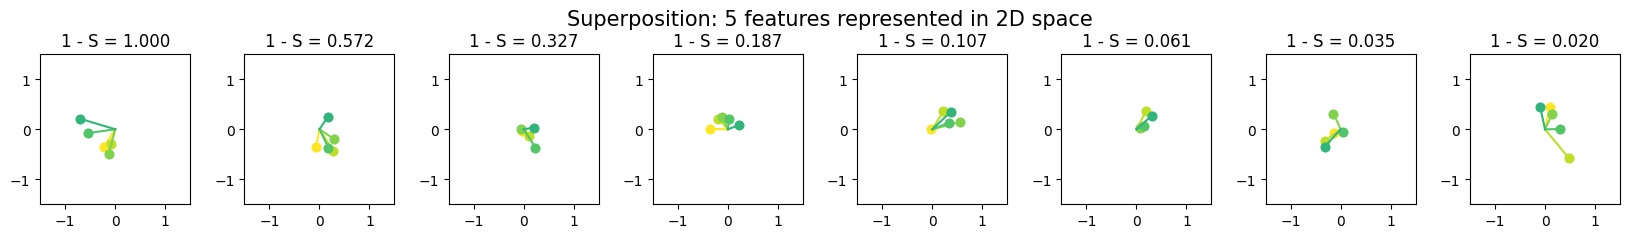

In [5]:
activation_fn_list = [F.relu, F.tanh, F.gelu, F.elu]
for activation_fn in activation_fn_list:
    print(activation_fn)
    diff_activation_runs(activation_fn)

<class 'torch.optim.adam.Adam'>


  0%|          | 0/10000 [00:00<?, ?it/s]

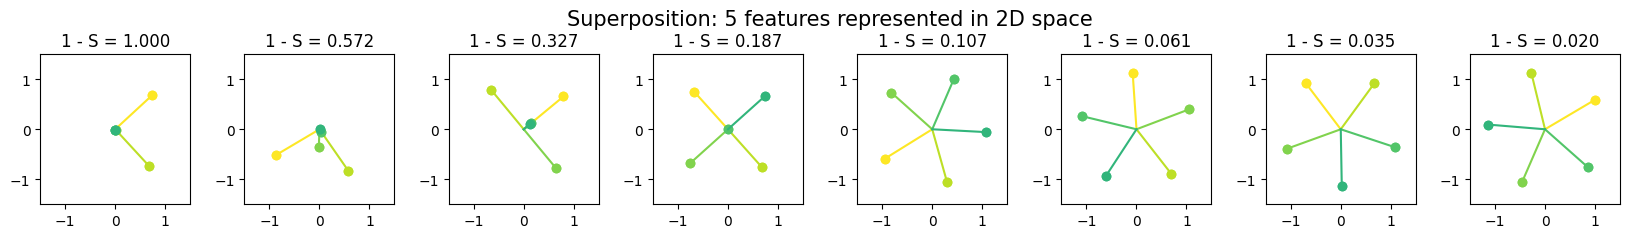

<class 'torch.optim.adamw.AdamW'>


  0%|          | 0/10000 [00:00<?, ?it/s]

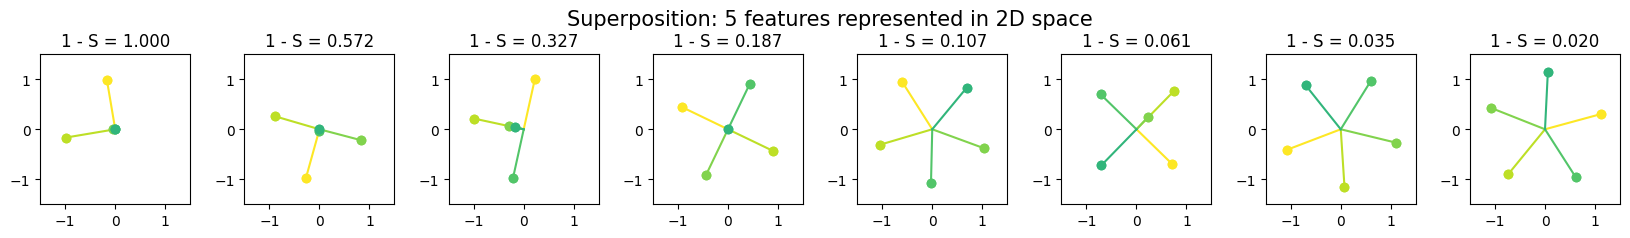

<class 'torch.optim.sgd.SGD'>


  0%|          | 0/10000 [00:00<?, ?it/s]

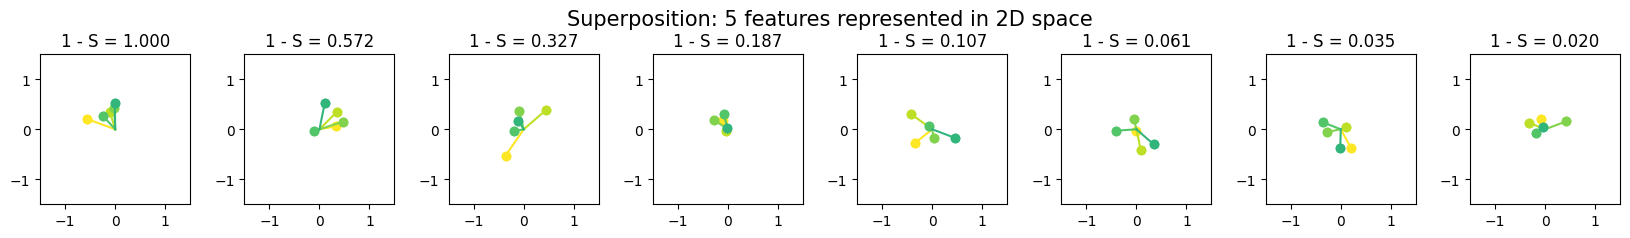

<class 'torch.optim.rmsprop.RMSprop'>


  0%|          | 0/10000 [00:00<?, ?it/s]

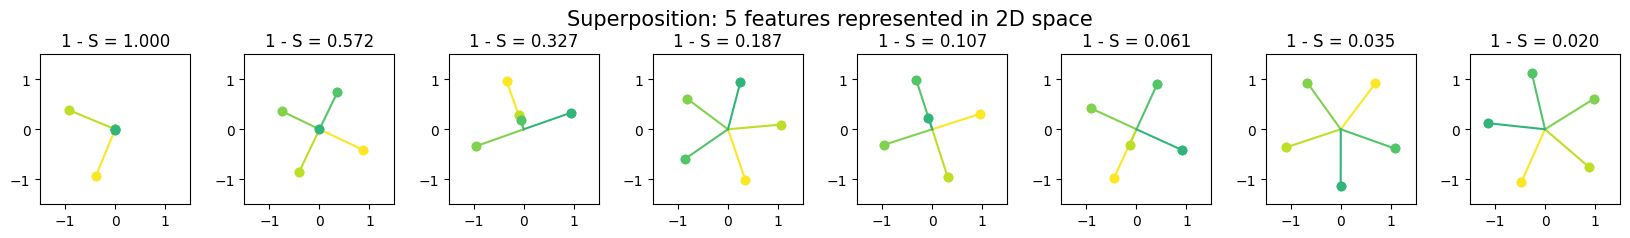

In [23]:
optim_fn_list = [t.optim.Adam, t.optim.AdamW, t.optim.SGD, t.optim.RMSprop]
for optim_fn in optim_fn_list:
    print(optim_fn)
    diff_optim_runs(optim_fn)

In [6]:
loss_df = pd.DataFrame(losses, columns=[str(np.round(prob.item(),3)) for prob in feature_prob])
loss_df["total_loss"] = loss_df.applxxy(lambda x: x.sum(),axis = 1)

In [10]:
fig = np.log(loss_df).plot(title = f"Loss Curves: {cfg.n_features} features represented in 2D space", height=600).update_layout(xaxis_title="Steps", yaxis_title="Log loss")
fig.write_image("higher_input_feature_plots/random_test.png")

In [55]:
np.log(loss_df).shape

(10000, 9)

In [23]:
model.W.detach()

tensor([[[-1.0012e+00,  5.3090e-03, -1.3018e-03,  2.9204e-03, -1.8344e-05,
           3.0509e-04, -8.9589e-04,  3.9268e-03],
         [-7.4695e-03, -1.0001e+00, -3.3194e-02, -4.7190e-03,  2.3203e-03,
          -9.4776e-05,  5.7381e-03,  1.6349e-03]],

        [[ 5.3261e-01,  8.1299e-01,  3.5071e-01,  8.3900e-02, -2.1440e-03,
          -4.1949e-03,  3.8958e-03,  5.5929e-04],
         [-8.6345e-01,  5.8639e-01, -5.3451e-03,  3.9437e-02,  3.5167e-03,
          -1.0321e-02, -1.8603e-03, -1.3443e-03]],

        [[ 8.0278e-01,  6.3544e-01, -6.2720e-01,  4.4717e-03, -7.6400e-01,
           2.2162e-03,  3.8097e-03, -1.2940e-03],
         [-6.4031e-01,  7.9172e-01, -7.8157e-01, -1.8915e-04,  6.1325e-01,
          -1.5616e-03, -2.9746e-03, -1.9245e-03]],

        [[ 7.0432e-01, -7.0888e-01,  5.1905e-03,  7.2486e-01, -7.1945e-01,
          -1.8857e-03,  4.6041e-03, -6.5931e-04],
         [ 7.2110e-01, -7.2199e-01, -9.8204e-03, -7.0787e-01,  7.0231e-01,
          -1.5765e-03, -9.3398e-03,  8.5092e

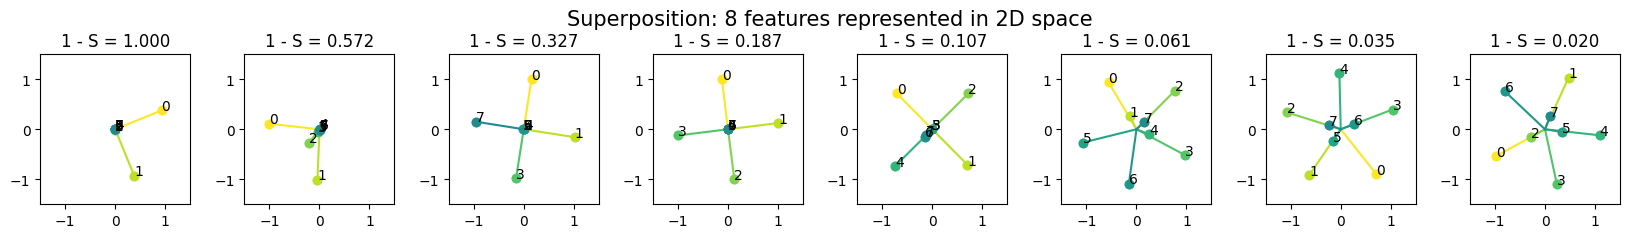

In [6]:
plot_features_in_2d(
    model.W.detach(),
    colors = model.importance,
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    subplot_titles = [f"1 - S = {i:.3f}" for i in feature_prob.squeeze()],
)

In [5]:
def different_input_features_runs(n_features):
    print(f"n_features:{n_features}")

    cfg = Config(
            n_instances = 8,
            n_features = n_features,
            n_hidden = 2,
        )

    
    # importance varies within features for each instance
    importance = feature_importance(cfg.n_features)
    
    # sparsity is the same for all features in a given instance, but varies over instances
    feature_prob = feature_probability(cfg.n_instances)

    model = Model(
        cfg = cfg,
        device = device,
        importance = importance,
        feature_probability = feature_prob,
    )
    summed_losses, losses = model.optimize(steps=10_000)

    results_dict = {}
    results_dict["W"] = model.W.detach()
    results_dict["b"] = model.b_final.detach()
    results_dict["summed_loss"] = summed_losses
    results_dict["losses"] = losses
    
    return results_dict